In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
def exp_plat(ym, k, x):
    return ym * (1 - np.exp(-k * x))

EIR = np.linspace(1, 100, dtype=np.float32)
k = 7 * 1e-2
ym = .8
prev = exp_plat(ym, k, EIR)

In [3]:
sample_size = 5
EIR_sample = np.random.randint(1,100,sample_size).astype(np.float32)

In [4]:
sigma = 0.1
def bounded(x, l, u):
    return np.minimum(np.maximum(x, l), u)

prev_sample = bounded(exp_plat(ym, k, EIR_sample) + np.random.normal(size=len(EIR_sample), scale=sigma), 0, 1).astype(np.float32)
pop_sample = np.maximum(np.random.normal(size=len(EIR_sample), loc=10000, scale=1000), 0.).astype(np.float32)

Text(0, 0.5, 'prev')

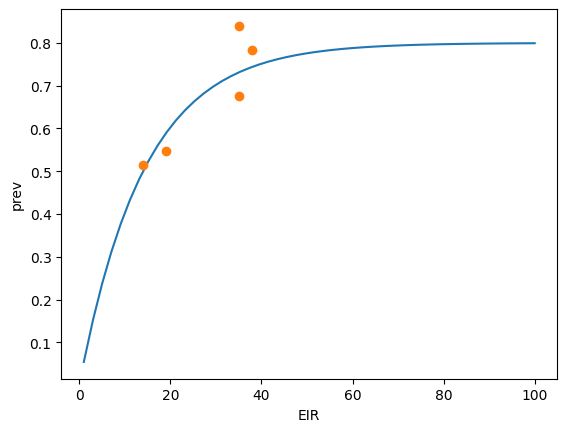

In [5]:
plt.plot(EIR, prev)
plt.plot(EIR_sample, prev_sample, 'o')
plt.xlabel('EIR')
plt.ylabel('prev')

In [6]:
import tensorflow_probability as tfp
tfd = tfp.distributions
import tensorflow as tf
import matplotlib.pyplot as plt

2022-10-31 15:10:04.255144: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-31 15:10:04.427130: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
from rpy2.robjects.packages import importr
import rpy2.robjects as ro
import copy
eq = importr('malariaEquilibrium')

In [35]:
r_default_params = eq.load_parameter_set()
ages = ro.FloatVector(range(100))

In [41]:
pop_sample_tf = tf.constant(pop_sample)

def single_prev(params, eir):
    states = eq.human_equilibrium(eir, ft = 0., p=params, age=ages)
    return sum(states.rx2['states'].rx(ro.IntVector(range(4,11)),'pos_M')) / sum(states.rx2['states'].rx(ro.IntVector(range(4,11)),'prop'))

def model_prev(q0, s2, rU, cD, g_inf, cU, kb, ub, uc, ud, kc, b0, b1, IB0, IC0, tau, phi0, phi1, mu, f, fd0, ad0, gd, eir):
    params = [q0, s2, rU, cD, g_inf, cU, kb, ub, uc, ud, kc, b0, b1, IB0, IC0, tau, phi0, phi1, mu, f, fd0, ad0, gd]
    if len(q0.shape) == 0:
        return 0
        params = [tf.expand_dims(p, axis=0) for p in params]
        eir = tf.expand_dims(eir, axis=0)
    batch_size = params[0].shape[0]
    sites = eir.shape[1]
    prev = np.zeros((batch_size, sites), dtype=np.float32)
    for b in range(batch_size):
        for n, p in zip(['Q0', 's2', 'rU', 'cD', 'g_inf', 'cU', 'kb', 'ub', 'uc', 'ud', 'kc', 'b0', 'b1', 'IB0', 'IC0', 'tau', 'phi0', 'phi1', 'mu', 'f', 'fd0', 'ad0', 'gd'], params):
            batch_params = copy.deepcopy(r_default_params)
            batch_params.rx2[n] = ro.FloatVector([p[b].numpy()])
        for e_i, e in enumerate(eir[b, :]):
            prev[b, e_i] = single_prev(batch_params, ro.FloatVector([e.numpy()]))
    return prev

def prob_prev(q0, s2, rU, cD, g_inf, cU, kb, ub, uc, ud, kc, b0, b1, IB0, IC0, tau, phi0, phi1, mu, f, fd0, ad0, gd, eir):
    prev_pred = model_prev(q0, s2, rU, cD, g_inf, cU, kb, ub, uc, ud, kc, b0, b1, IB0, IC0, tau, phi0, phi1, mu, f, fd0, ad0, gd, eir)
    return tfd.Independent(
        tfd.Binomial(total_count=pop_sample_tf[tf.newaxis, :], probs=prev_pred),
        reinterpreted_batch_ndims=1
    )

In [42]:
from collections import OrderedDict
EIR_sigma = 1
EIR_guesses = bounded(EIR_sample + np.random.normal(size=len(EIR_sample), scale=EIR_sigma).astype(np.float32), 20., 40.)

joint_dist = tfp.distributions.JointDistributionNamed(
    OrderedDict(
        Q0 = tfd.Beta(1., 1.),
        s2 = tfd.Uniform(1., 3.),
        rU = tfd.Uniform(1/1000, 1/30),
        cD = tfd.Beta(1., 1.),
        g_inf = tfd.LogNormal(0., 1.),
        cU = tfd.Beta(1., 1.),
        kb = tfd.Gamma(4., 2.),
        ub = tfd.LogNormal(0., 1.),
        uc = tfd.LogNormal(0., 1.),
        ud = tfd.LogNormal(0., 1.),
        kc =  tfd.Gamma(4., 2.),
        b0 = tfd.Beta(1., 1.),
        b1 = tfd.Beta(1., 1.),
        IB0 = tfd.Gamma(5., .1),
        IC0 = tfd.Gamma(5., .1),
        tau = tfd.LogNormal(0., 1.),
        phi0 = tfd.Beta(1., 1.),
        phi1 = tfd.Beta(1., 1.),
        mu = tfd.Beta(1., 1.),
        f = tfd.Beta(1., 1.),
        fd0 = tfd.Beta(1., 1.),
        ad0 = tfd.Uniform(20 * 365, 40 * 365),
        gd = tfd.LogNormal(0., 1.),
        eir = tfd.Independent(tfd.TruncatedNormal(loc=EIR_guesses, scale=np.full(sample_size, EIR_sigma, dtype=np.float32), low=0, high=100), reinterpreted_batch_ndims=1),
        prev = lambda Q0, s2, rU, cD, g_inf, cU, kb, ub, uc, ud, kc, b0, b1, IB0, IC0, tau, phi0, phi1, mu, f, fd0, ad0, gd, eir : prob_prev(Q0, s2, rU, cD, g_inf, cU, kb, ub, uc, ud, kc, b0, b1, IB0, IC0, tau, phi0, phi1, mu, f, fd0, ad0, gd, eir)
    )
)

In [30]:
prior = joint_dist.sample(100)

AttributeError: 'Tensor' object has no attribute 'numpy'

In [ ]:
default_params = pd.read_csv('default_params.csv')
default_dict = dict(default_params.itertuples(index=False))
cols = 4
rows = (len(prior) // cols + 1)
prior_keys = list(prior.keys())
bounds_dict = { n: (l, u) for n, l, u in bounds.itertuples(index=False) }
default_dict = dict(default_params.itertuples(index=False))
plt.tight_layout()
fig, axes = plt.subplots(rows, cols, figsize=(cols * rows, 30))
for c in range(cols):
    for r in range(rows):
        if cols * r + c < len(prior_keys):
            ax = axes[r][c]
            k = prior_keys[cols * r + c]
            ax.hist(prior[k].numpy().flatten(), bins=100)
            if k in default_dict.keys():
                ax.vlines(default_dict[k], 0, ax.get_ylim()[1], color='green')
            elif k == 'eir':
                ax.vlines(EIR_sample, 0, ax.get_ylim()[1], color='orange')
            elif k == 'prev':
                ax.vlines(prev_sample * pop_sample, 0, ax.get_ylim()[1], color='orange')
            ax.set_title(k)
        else:
            fig.delaxes(axes[r][c])

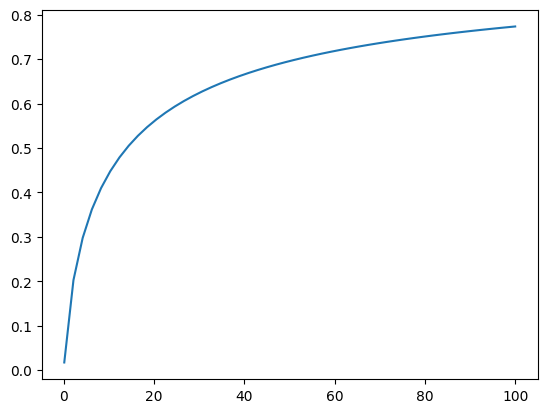

In [39]:
eir_space = np.linspace(.1, 100., dtype=np.float32)
eir_prev = model_prev(
    *[
        tf.constant(default_dict[name], dtype=tf.float32)
        for name in [
            'Q0',
            's2',
            'rU',
            'cD',
            'g_inf',
            'cU',
            'kb',
            'ub',
            'uc',
            'ud',
            'kc',
            'b0',
            'b1',
            'IB0',
            'IC0',
            'tau',
            'phi0',
            'phi1',
            'mu',
            'f',
            'fd0',
            'ad0',
            'gd'
        ]
    ],
    eir_space
)
plt.plot(eir_space, eir_prev[0])

In [43]:
%%time
# Initialize the HMC transition kernel.
tf.config.experimental.enable_tensor_float_32_execution(False)
num_results = 100#int(1e3)
num_burnin_steps = 100#int(1e3)

num_chains = 10

observed_prev = tf.constant(pop_sample * prev_sample)
initial_state_dict = joint_dist.sample(num_chains)
initial_state_dict.pop('prev')
initial_state = list(initial_state_dict.values())

def log_prob(*state):
    #return prob_prev(*state).log_prob(observed_prev)
    return joint_dist.log_prob(
        *state,
        observed_prev
    )

mcmc = tfp.mcmc.SimpleStepSizeAdaptation(
    inner_kernel = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=log_prob,
        num_leapfrog_steps=3,
        step_size=1.
    ),
    num_adaptation_steps=int(num_burnin_steps * 0.8)
)

def run_chain():
    return tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=initial_state,
      parallel_iterations=num_chains,
      kernel=mcmc,
      trace_fn=lambda _, pkr: pkr.inner_results.is_accepted
    )

samples, acceptance = run_chain()

CPU times: user 1h 21min 8s, sys: 18.8 s, total: 1h 21min 27s
Wall time: 1h 20min 49s


In [44]:
acceptance.numpy().mean()

0.001

In [45]:
posterior = dict(zip(initial_state_dict.keys(), samples))

<Figure size 640x480 with 0 Axes>

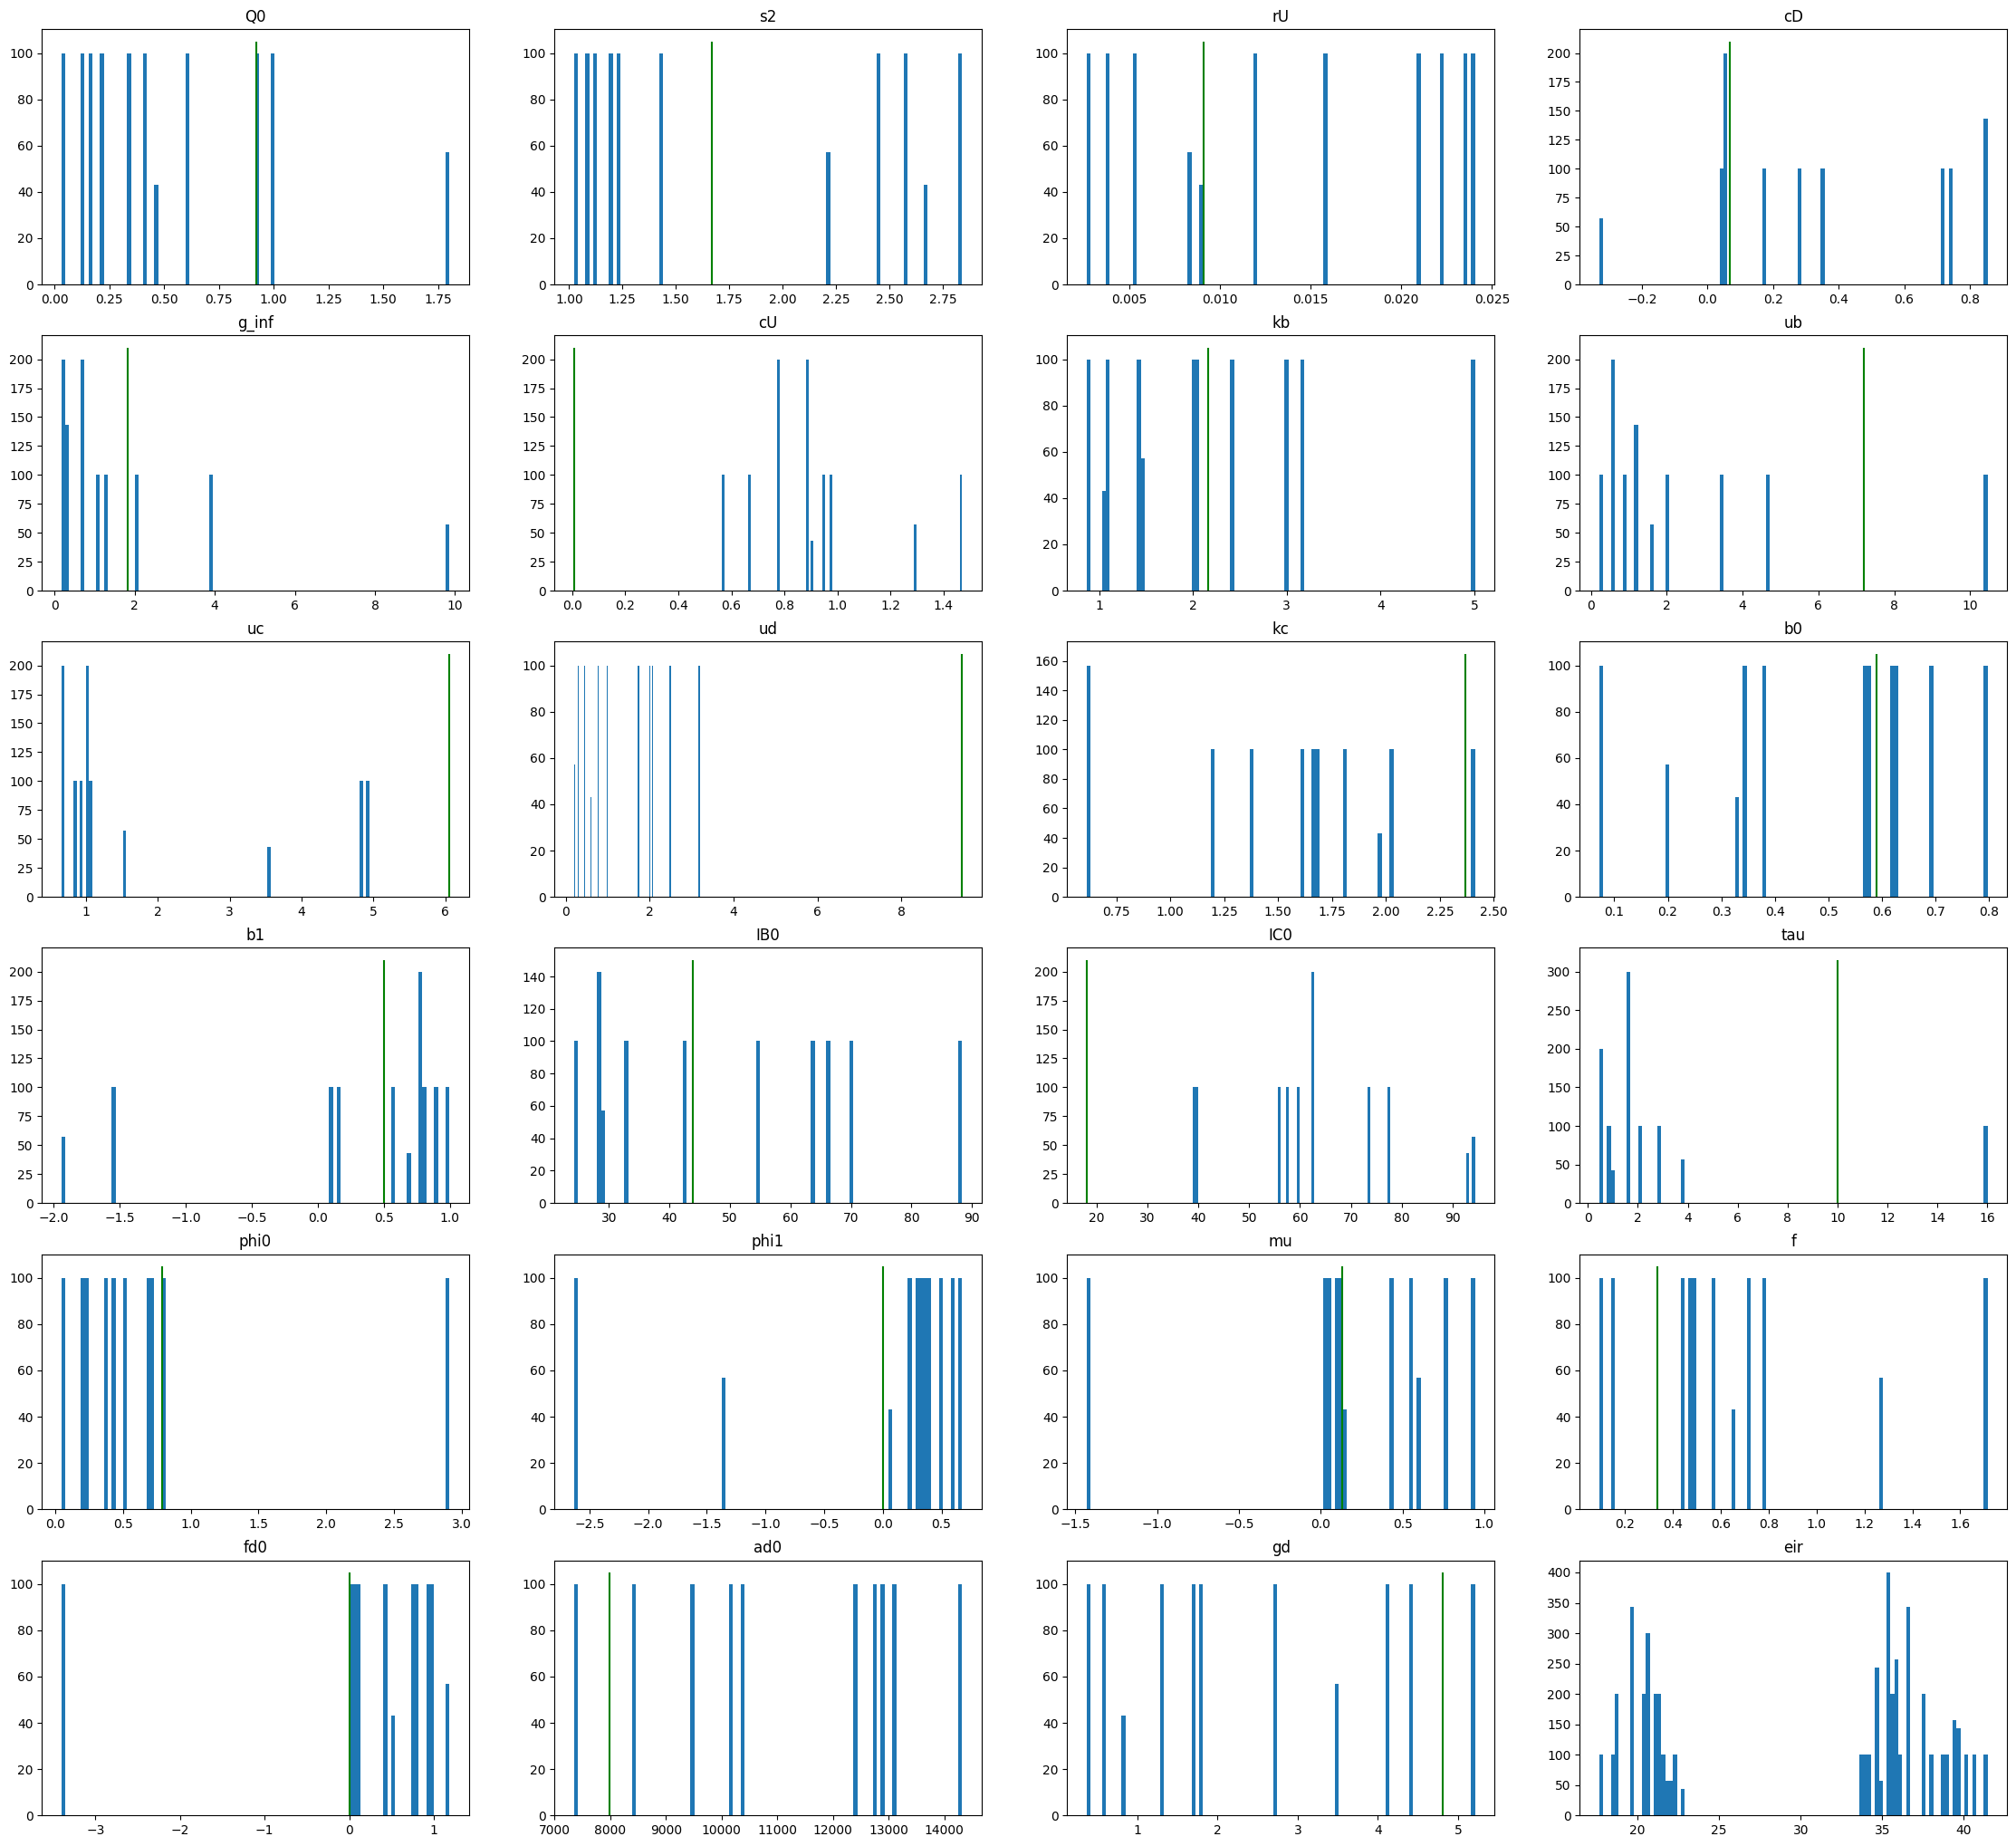

In [46]:
cols = 4
rows = (len(posterior) // cols + 1)
posterior_keys = list(posterior.keys())
bounds_dict = { n: (l, u) for n, l, u in bounds.itertuples(index=False) }
plt.tight_layout()
fig, axes = plt.subplots(rows, cols, figsize=(cols * rows, 30))
for c in range(cols):
    for r in range(rows):
        if cols * r + c < len(posterior_keys):
            ax = axes[r][c]
            k = posterior_keys[cols * r + c]
            ax.hist(posterior[k].numpy().flatten(), bins=100)
            if k == 'prev':
                ax.vlines(np.average(prev_sample * pop_sample), 0, ax.get_ylim()[1], color='orange')
            if k in default_dict.keys():
                ax.vlines(default_dict[k], 0, ax.get_ylim()[1], color='green')
            ax.set_title(k)
        else:
            fig.delaxes(axes[r][c])

<Figure size 640x480 with 0 Axes>

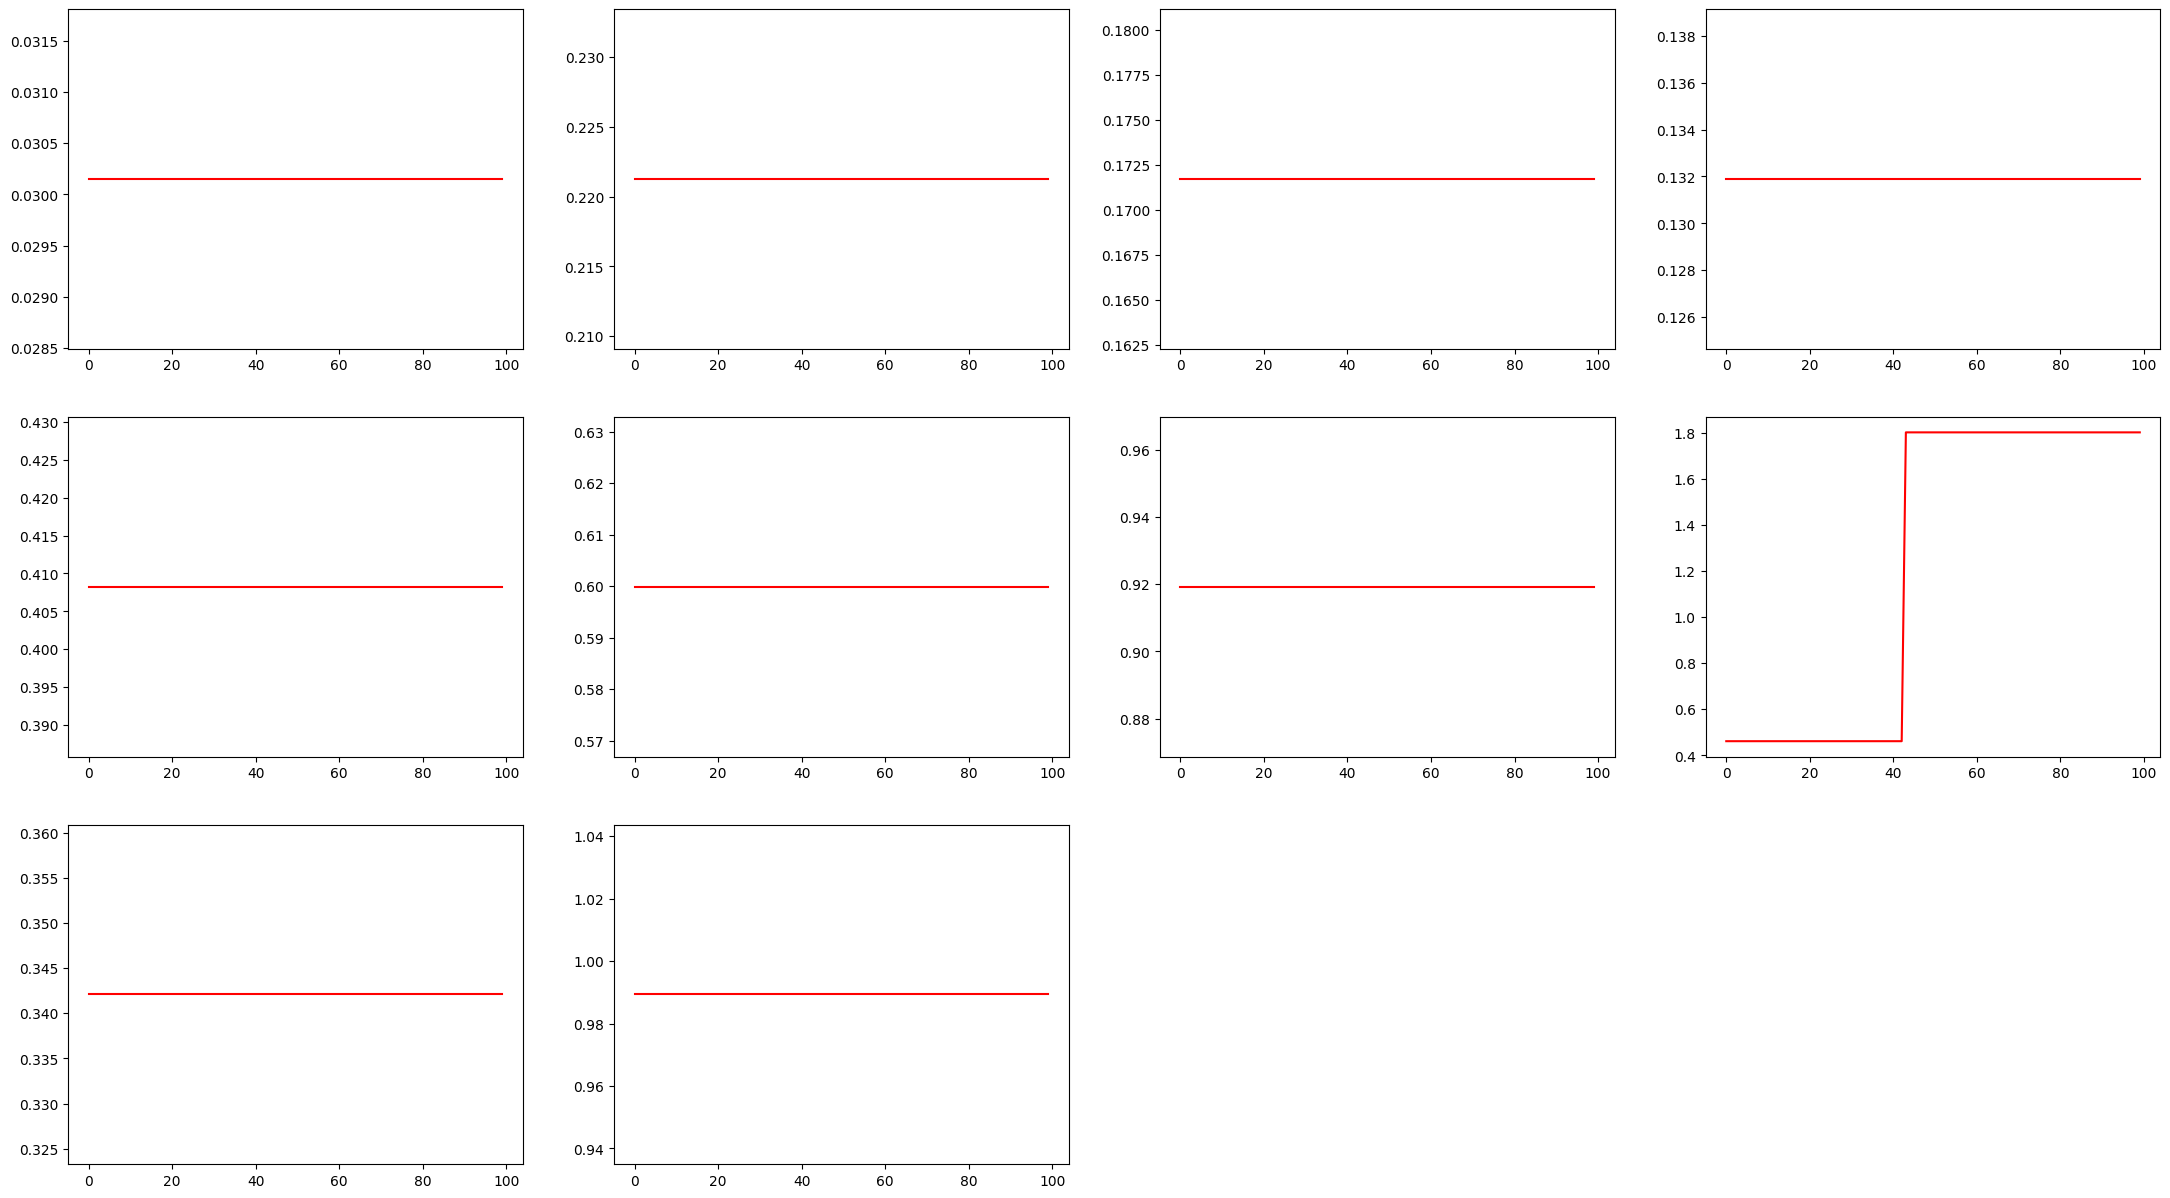

In [47]:
variable = 0
cols = 4
rows = (num_chains // cols + 1)
plt.tight_layout()
fig, axes = plt.subplots(rows, cols, figsize=(cols * rows + 15, 15))
for c in range(cols):
    for r in range(rows):
        if len(axes.shape) == 1:
            ax = axes[c]
        else:
            ax = axes[r][c]
        i = cols * r + c
        if i < num_chains:
            ax.plot(samples[variable][:, i:i + 1], color='red')
        else:
            fig.delaxes(ax)

(array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [1., 0., 0., ..., 0., 0., 0.],
        [5., 0., 0., ..., 0., 0., 0.]]),
 array([2.60176468e+00, 8.54703688e+05, 1.70940475e+06, 2.56410600e+06,
        3.41880700e+06, 4.27350800e+06, 5.12820900e+06, 5.98291050e+06,
        6.83761150e+06, 7.69231250e+06, 8.54701400e+06, 9.40171500e+06,
        1.02564160e+07, 1.11111170e+07, 1.19658180e+07, 1.28205190e+07,
        1.36752200e+07, 1.45299210e+07, 1.53846220e+07, 1.62393230e+07,
        1.70940240e+07, 1.79487260e+07, 1.88034260e+07, 1.96581280e+07,
        2.05128280e+07, 2.13675300e+07, 2.22222320e+07, 2.30769320e+07,
        2.39316340e+07, 2.47863340e+07, 2.56410360e+07, 2.64957360e+07,
        2.73504380e+07, 2.82051380e+07, 2.90598400e+07, 2.99145400e+07,
        3.07692420e+07, 3.16239440e+07, 3.24786440e+07, 3.33333460e+07,
        3.41880480e+07, 3.50427

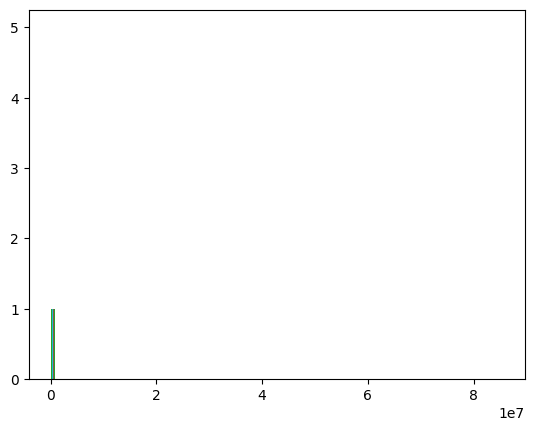

In [48]:
plt.hist(tfp.mcmc.potential_scale_reduction(samples), bins=100)

In [49]:
tfp.mcmc.potential_scale_reduction(samples)

[<tf.Tensor: shape=(), dtype=float32, numpy=5.181368>,
 <tf.Tensor: shape=(), dtype=float32, numpy=121.32131>,
 <tf.Tensor: shape=(), dtype=float32, numpy=6122.205>,
 <tf.Tensor: shape=(), dtype=float32, numpy=4.068551>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.6017647>,
 <tf.Tensor: shape=(), dtype=float32, numpy=19.50058>,
 <tf.Tensor: shape=(), dtype=float32, numpy=394.51004>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1852.6195>,
 <tf.Tensor: shape=(), dtype=float32, numpy=31.904947>,
 <tf.Tensor: shape=(), dtype=float32, numpy=256.16022>,
 <tf.Tensor: shape=(), dtype=float32, numpy=6.9619083>,
 <tf.Tensor: shape=(), dtype=float32, numpy=140.06264>,
 <tf.Tensor: shape=(), dtype=float32, numpy=5.4376206>,
 <tf.Tensor: shape=(), dtype=float32, numpy=22048.72>,
 <tf.Tensor: shape=(), dtype=float32, numpy=5096.588>,
 <tf.Tensor: shape=(), dtype=float32, numpy=130.94937>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2015068.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=23.49762>,